In [1]:
import os
import sys
import polars as pl
import pysam
from pathlib import Path
import numpy as np
from typing import Tuple, List, Dict


notebook_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(notebook_dir)



project_path = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding"
model = "AR-NR3C1-Contrasting"
sample = "chr7"
jaspar_file = f"/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/src/inference/interpretability/motifs/{model}.jaspar"  # Update this path

pileup_dir = Path("/data1/projects/human_cistrome/aligned_chip_data/merged_cell_lines/22Rv1/pileup_mod/")


df = pl.read_parquet("/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding/data/processed_results/AR-NR3C1-Contrasting_chr7_processed.parquet", 
                    # columns=["chr_name", "start", "end", "cell_line", "targets", "predicted", "weights", "probabilities", "attributions"],
                    # low_memory=True,                        # Reduce memory usage
                    parallel="columns",                     # Enable parallel reading
                    use_statistics=True,                    # Use parquet statistics
                    memory_map=True)                         # Use memory mapping
df = df.rename({"chr_name": "chr"})



In [2]:
# get count of 1s and 0s in targets column and predicted column
# df['targets'].value_counts()
df.select(['predicted', 'targets']).group_by(['predicted', 'targets']).count()



/tmp/ipykernel_128084/4213590499.py:3: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  df.select(['predicted', 'targets']).group_by(['predicted', 'targets']).count()


predicted,targets,count
f64,f64,u32
0.0,1.0,69
1.0,0.0,531
1.0,1.0,4002
0.0,0.0,894


In [3]:
# create df with probabilities more that .99
df_AR = df.filter(pl.col('probabilities') > 0.99)
df_NR3C1 = df.filter(pl.col('probabilities') < 0.01)


In [4]:
from tqdm import tqdm

def process_pileups(pileup_dir: Path, chr_name: str, start: int, end: int) -> pl.DataFrame:
    """Process pileup files for a given genomic region with 4096bp context."""
    context_length = 4_096
    interval_length = end - start
    extra_seq = context_length - interval_length
    extra_left_seq = extra_seq // 2
    extra_right_seq = extra_seq - extra_left_seq
    start -= extra_left_seq
    end += extra_right_seq
    
    # Get the pileup file for the given chromosome
    pileup_file = pileup_dir / f"{chr_name}.pileup.gz"
    assert pileup_file.exists(), f"pileup file for {pileup_file} does not exist"
    
    tabixfile = pysam.TabixFile(str(pileup_file))
    records = []
    for rec in tabixfile.fetch(chr_name, start, end):
        records.append(rec.split("\t"))
    
    # Convert records to a DataFrame using Polars
    df = pl.DataFrame({
        "chr_name": [rec[0] for rec in records],
        "position": [int(rec[1]) for rec in records],
        "nucleotide": [rec[2] for rec in records],
        "count": [float(rec[3]) for rec in records],
    })
    
    return df


def create_position_to_count_mapping(pileup_df: pl.DataFrame) -> Dict[int, float]:
    """Create a mapping from genomic position to ATAC count."""
    return dict(zip(pileup_df['position'].to_list(), pileup_df['count'].to_list()))


def create_atac_pileup_array(position_count_map: Dict[int, float], 
                            start_pos: int, 
                            length: int = 4096) -> np.ndarray:
    """Create ATAC pileup array for a genomic region."""
    atac_array = np.zeros(length)
    
    for i in range(length):
        pos = start_pos + i
        if pos in position_count_map:
            atac_array[i] = position_count_map[pos]
    
    return atac_array


def reshape_attributions_fast(df: pl.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """
    Fast reshape attribution data using vectorized operations.
    
    Returns:
        attrs_list: Attribution scores for ACGT (shape: n_samples, 4, 4096)
        atac_attribution_list: ATAC attribution scores (shape: n_samples, 4096)
    """
    print("Reshaping attribution data...")
    # Convert to numpy array more efficiently
    attributions = np.array(df['attributions'].to_list())
    
    # Vectorized reshape - much faster than loops
    reshaped = attributions.reshape(-1, 4096, 5)
    
    # Split into ACGT and ATAC components
    attrs_list = reshaped[..., :4].transpose(0, 2, 1)  # Shape: (n_samples, 4, 4096)
    atac_attribution_list = reshaped[..., 4]  # Shape: (n_samples, 4096)
            
    return attrs_list, atac_attribution_list


def process_pileups_batch(pileup_dir: Path, regions_df: pl.DataFrame) -> Dict[int, np.ndarray]:
    """Process multiple pileup regions for a single cell line efficiently."""
    context_length = 4_096
    atac_arrays = {}
    
    # Get unique chromosomes to minimize file operations
    chromosomes = regions_df['chr'].unique().to_list()
    chr_tabix_files = {}
    
    # Open all needed tabix files once
    print(f"Opening tabix files for {len(chromosomes)} chromosomes...")
    for chr_name in tqdm(chromosomes, desc="Loading chromosome files", leave=False):
        pileup_file = pileup_dir / f"{chr_name}.pileup.gz"
        if pileup_file.exists():
            chr_tabix_files[chr_name] = pysam.TabixFile(str(pileup_file))
    
    # Process each region
    region_iterator = regions_df.iter_rows(named=True)
    total_regions = len(regions_df)
    
    for row in tqdm(region_iterator, total=total_regions, desc="Processing regions", leave=False):
        idx, chr_name, start, end = row['idx'], row['chr'], row['start'], row['end']
        
        # Calculate adjusted coordinates
        interval_length = end - start
        extra_seq = context_length - interval_length
        extra_left_seq = extra_seq // 2
        extra_right_seq = extra_seq - extra_left_seq
        adj_start = start - extra_left_seq
        adj_end = end + extra_right_seq
        
        # Initialize array
        atac_array = np.zeros(context_length)
        
        # Get data if tabix file exists
        if chr_name in chr_tabix_files:
            tabixfile = chr_tabix_files[chr_name]
            
            # Collect all positions and counts at once
            positions = []
            counts = []
            
            try:
                for rec in tabixfile.fetch(chr_name, adj_start, adj_end):
                    fields = rec.split("\t")
                    positions.append(int(fields[1]))
                    counts.append(float(fields[3]))
                
                # Vectorized assignment
                if positions:
                    positions = np.array(positions)
                    counts = np.array(counts)
                    
                    # Calculate array indices
                    array_indices = positions - adj_start
                    
                    # Filter valid indices
                    valid_mask = (array_indices >= 0) & (array_indices < context_length)
                    valid_indices = array_indices[valid_mask]
                    valid_counts = counts[valid_mask]
                    
                    # Assign values
                    atac_array[valid_indices] = valid_counts
                    
            except Exception as e:
                print(f"Warning: Could not fetch data for {chr_name}:{adj_start}-{adj_end}: {e}")
        
        atac_arrays[idx] = atac_array
    
    # Close tabix files
    print("Closing tabix files...")
    for tabixfile in chr_tabix_files.values():
        tabixfile.close()
    
    return atac_arrays


def process_region_data_fast(df: pl.DataFrame, base_pileup_dir: Path = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Fast process both attribution and pileup data using Polars optimizations.
    
    Args:
        df: DataFrame containing attribution data and region info (chr, start, end, cell_line columns)
        base_pileup_dir: Base directory path for pileup files (optional, uses default if None)
    
    Returns:
        attrs_list: Attribution scores for ACGT
        atac_attribution_list: ATAC attribution scores
        atac_pileup_list: Raw ATAC pileup counts
    """
    if base_pileup_dir is None:
        base_pileup_dir = Path("/data1/projects/human_cistrome/aligned_chip_data/merged_cell_lines/")
    
    print(f"Processing {len(df)} regions across cell lines...")
    
    # Get attribution data (fast vectorized version)
    attrs_list, atac_attribution_list = reshape_attributions_fast(df)
    
    # Add row index for tracking
    df_with_idx = df.with_row_index("idx")
    
    # Group by cell line for batch processing
    atac_pileup_arrays = [None] * len(df)
    cell_line_groups = list(df_with_idx.group_by("cell_line"))
    
    print(f"Processing {len(cell_line_groups)} cell lines...")
    
    for cell_line, group_df in tqdm(cell_line_groups, desc="Processing cell lines"):
        cell_line_name = cell_line[0]
        
        # Construct cell-line specific pileup directory
        pileup_dir = base_pileup_dir / cell_line_name / "pileup_mod"
        
        if not pileup_dir.exists():
            print(f"Warning: Pileup directory does not exist: {pileup_dir}")
            # Fill with zeros for this cell line
            for row in group_df.iter_rows(named=True):
                atac_pileup_arrays[row['idx']] = np.zeros(4096)
            continue
        
        print(f"Processing {len(group_df)} regions for cell line: {cell_line_name}")
        
        # Process all regions for this cell line at once
        atac_arrays_dict = process_pileups_batch(pileup_dir, group_df)
        
        # Assign to the correct positions in the final array
        for idx, atac_array in atac_arrays_dict.items():
            atac_pileup_arrays[idx] = atac_array
    
    print("Converting to final numpy arrays...")
    # Convert to numpy array
    atac_pileup_list = np.array(atac_pileup_arrays)
    
    print("Processing complete!")
    return attrs_list, atac_attribution_list, atac_pileup_list

attrs_list, atac_attribution_list, atac_pileup_list = process_region_data_fast(df)

Processing 5496 regions across cell lines...
Reshaping attribution data...
Processing 7 cell lines...


Processing cell lines:   0%|          | 0/7 [00:00<?, ?it/s]

Processing 2617 regions for cell line: LNCAP
Opening tabix files for 1 chromosomes...


Processing cell lines:  14%|█▍        | 1/7 [01:04<06:25, 64.28s/it]

Closing tabix files...
Processing 760 regions for cell line: VCAP
Opening tabix files for 1 chromosomes...


Processing cell lines:  29%|██▊       | 2/7 [01:45<04:12, 50.55s/it]

Closing tabix files...
Processing 408 regions for cell line: THP-1
Opening tabix files for 1 chromosomes...


Processing cell lines:  43%|████▎     | 3/7 [02:08<02:32, 38.11s/it]

Closing tabix files...
Processing 2 regions for cell line: HEK_293
Opening tabix files for 1 chromosomes...


Processing cell lines:  57%|█████▋    | 4/7 [02:10<01:11, 23.96s/it]

Closing tabix files...
Processing 1010 regions for cell line: A549
Opening tabix files for 1 chromosomes...


Processing cell lines:  71%|███████▏  | 5/7 [02:44<00:54, 27.39s/it]

Closing tabix files...
Processing 52 regions for cell line: MCF7
Opening tabix files for 1 chromosomes...


Processing cell lines:  86%|████████▌ | 6/7 [02:49<00:19, 19.91s/it]

Closing tabix files...
Processing 647 regions for cell line: 22Rv1
Opening tabix files for 1 chromosomes...


Processing cell lines: 100%|██████████| 7/7 [03:18<00:00, 28.42s/it]


Closing tabix files...
Converting to final numpy arrays...
Processing complete!


In [5]:
# Import additional required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo
from tangermeme.seqlet import recursive_seqlets


def get_seqlets(attrs_list, use_absolute_values=False):
    """Extract seqlets from attribution data."""
    attrs_array = np.stack(attrs_list, axis=0)

    # Sum attributions across one-hot encoded dimension
    summed_attrs = attrs_array.sum(axis=1)

    # Optionally use absolute values
    if use_absolute_values:
        summed_attrs = np.abs(summed_attrs)

    seqlets = recursive_seqlets(summed_attrs)

    nt_idx = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}

    # Add sequences to seqlets df
    sequences = []
    for i in range(len(seqlets)):
        sample = seqlets.iloc[i]
        start = int(sample['start'])
        end = int(sample['end'])
        sample_idx = int(sample['example_idx'])

        sample_attrs = attrs_array[sample_idx, :, start:end].T.squeeze()
        hits = np.argmax(sample_attrs, axis=1)
        seq = ''.join([nt_idx[i] for i in hits])
        sequences.append(seq)
    
    seqlets['sequence'] = sequences
    return seqlets


def plot_seqlet_with_atac(seqlets, attrs_list, atac_attribution_list, atac_pileup_list, 
                         sample_rank=0, context_size=20, colormap='RdBu_r'):
    """
    Create a two-panel plot:
    - Top: DNA base attributions (logo plot)  
    - Bottom: ATAC pileup with attribution heatmap background
    
    Parameters:
    -----------
    seqlets : pandas.DataFrame
        DataFrame containing sequence information
    attrs_list : list or np.ndarray
        List/array of DNA attribution arrays
    atac_attribution_list : list or np.ndarray
        List/array of ATAC attribution data arrays
    atac_pileup_list : list or np.ndarray
        List/array of ATAC-seq pileup data arrays
    sample_rank : int, default=0
        Index of the sample to plot
    context_size : int, default=20
        Size of context around the seqlet to include in the plot
    colormap : str, default='RdBu_r'
        Matplotlib colormap for the attribution heatmap
    """
    # Extract sample information
    sample = seqlets.iloc[[sample_rank]]
    slice_idx = int(sample['example_idx'].tolist()[0])
    sequence = sample['sequence'].tolist()[0]
    start = int(sample['start'].tolist()[0])
    end = int(sample['end'].tolist()[0])

    # Calculate the seqlet center and window boundaries
    seqlet_center = (start + end) // 2
    seqlet_length = end - start
    
    # Calculate window with context - use the seqlet length + context on both sides
    total_window_size = seqlet_length + (2 * context_size)
    window_start = seqlet_center - (total_window_size // 2)
    window_end = seqlet_center + (total_window_size // 2)
    
    # Ensure window is within data bounds (all arrays are 4096 long)
    window_start = max(0, window_start)
    window_end = min(4096, window_end)
    
    # Adjust if window got truncated to maintain consistent size
    if window_end - window_start < total_window_size:
        if window_start == 0:
            window_end = min(4096, window_start + total_window_size)
        elif window_end == 4096:
            window_start = max(0, window_end - total_window_size)
    
    print(f"Seqlet: {start}-{end} (center: {seqlet_center})")
    print(f"Window: {window_start}-{window_end} (size: {window_end - window_start})")
    
    # Create identical coordinate arrays for both plots
    plot_coords = np.arange(window_start, window_end)
    
    # Get and window all data using IDENTICAL indices
    X_attr = attrs_list[slice_idx].astype(np.float64)
    atac_attr = atac_attribution_list[slice_idx].astype(np.float64)
    atac_pileup = atac_pileup_list[slice_idx].astype(np.float64)
    
    # Apply identical windowing to all arrays
    X_attr_windowed = X_attr[:, window_start:window_end]
    atac_attr_windowed = atac_attr[window_start:window_end]
    atac_pileup_windowed = atac_pileup[window_start:window_end]
    
    print(f"Windowed shapes: DNA={X_attr_windowed.shape}, ATAC_attr={atac_attr_windowed.shape}, ATAC_pileup={atac_pileup_windowed.shape}")

    # Create figure with custom layout for colorbar positioning
    fig = plt.figure(figsize=(18, 10), dpi=300)
    
    # Create subplot layout with space for colorbar on right
    gs = fig.add_gridspec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], 
                         hspace=0.3, wspace=0.02)
    
    # Create subplots
    ax1 = fig.add_subplot(gs[0, 0])  # Top panel for DNA
    ax2 = fig.add_subplot(gs[1, 0])  # Bottom panel for ATAC
    cax = fig.add_subplot(gs[1, 1])  # Colorbar

    # Top panel: DNA Attribution logo plot
    plot_logo(X_attr_windowed, ax=ax1)
    
    # Set x-ticks to show genomic coordinates that match the ATAC plot exactly
    n_ticks = 8
    tick_positions = np.linspace(0, len(plot_coords)-1, n_ticks)
    tick_labels = np.linspace(plot_coords[0], plot_coords[-1], n_ticks).astype(int)
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels)
    ax1.set_xlabel("Genomic Coordinate")
    ax1.set_ylabel("DNA Attributions")
    ax1.set_title(f"DNA Base Attributions | Sample: {slice_idx} | {sequence}")

    # Bottom panel: ATAC pileup with attribution heatmap background
    # Create heatmap background for ATAC attribution
    heatmap_height = 25
    attr_heatmap = np.tile(atac_attr_windowed, (heatmap_height, 1))
    
    # Determine y-axis limits based on pileup data
    max_pileup = np.max(atac_pileup_windowed) if len(atac_pileup_windowed) > 0 else 1
    y_max = max_pileup * 1.1
    
    # Create the heatmap background using the SAME coordinate system as DNA plot
    im = ax2.imshow(attr_heatmap, 
                    cmap=colormap,
                    aspect='auto',
                    extent=[plot_coords[0], plot_coords[-1], 0, y_max],
                    alpha=0.7,
                    interpolation='bilinear')
    
    # Plot ATAC pileup as line on top using the SAME coordinates as DNA plot
    ax2.plot(plot_coords, atac_pileup_windowed, color='black', linewidth=2.5, 
             label='ATAC-seq Pileup', alpha=0.9)
    
    # Set x-limits to match DNA plot exactly
    ax2.set_xlim(plot_coords[0], plot_coords[-1])
    
    # Add colorbar to the dedicated axis on the far right
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('ATAC Attribution', rotation=270, labelpad=15, fontsize=11)
    
    # Format bottom panel
    ax2.set_xlabel("Genomic Coordinate")
    ax2.set_ylabel("ATAC-seq Signal")
    ax2.set_title(f"ATAC Pileup with Attribution Heatmap | Sample: {slice_idx}")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.show()


# Example usage:
# seqlets = get_seqlets(attrs_list)
# plot_seqlet_with_atac(seqlets, attrs_list, atac_attribution_list, atac_pileup_list, sample_rank=0)
# Example usage:
# seqlets = get_seqlets(attrs_list)
# plot_seqlet_with_atac(seqlets, attrs_list, atac_attribution_list, atac_pileup_list, sample_rank=0)

Matplotlib is building the font cache; this may take a moment.


In [6]:
seqlets = get_seqlets(attrs_list)
# filtered_seqlets = seqlets[seqlets["sequence"] == "AAAAA"]
# filtered_seqlets
seqlets

,example_idx,start,end,attribution,p-value,sequence
0,4037,2087,2096,-28.812935,0.000001,CCACACATA
1,161,1979,1985,13.678400,0.000003,TTAAAC
2,1406,2429,2439,-22.882403,0.000003,ACATACTTAA
3,473,2006,2030,30.736800,0.000003,AAATTTCGAGTCAGAAAAAAGAAG
4,4287,1717,1726,17.624079,0.000004,TCGAAAGCT
...,...,...,...,...,...,...
31380,258,680,685,1.781722,0.009957,AAATA
31381,1406,1289,1294,2.085601,0.009957,ATTGA
31382,3154,311,316,1.615625,0.009957,AAAAA
31383,1532,1808,1813,1.588131,0.009957,AAGAA


In [7]:
print(attrs_list.shape)
print(atac_attribution_list.shape)
print(atac_pileup_list.shape)

(5496, 4, 4096)
(5496, 4096)
(5496, 4096)


Seqlet: 1979-1985 (center: 1982)
Window: 0-4006 (size: 4006)
Windowed shapes: DNA=(4, 4006), ATAC_attr=(4006,), ATAC_pileup=(4006,)


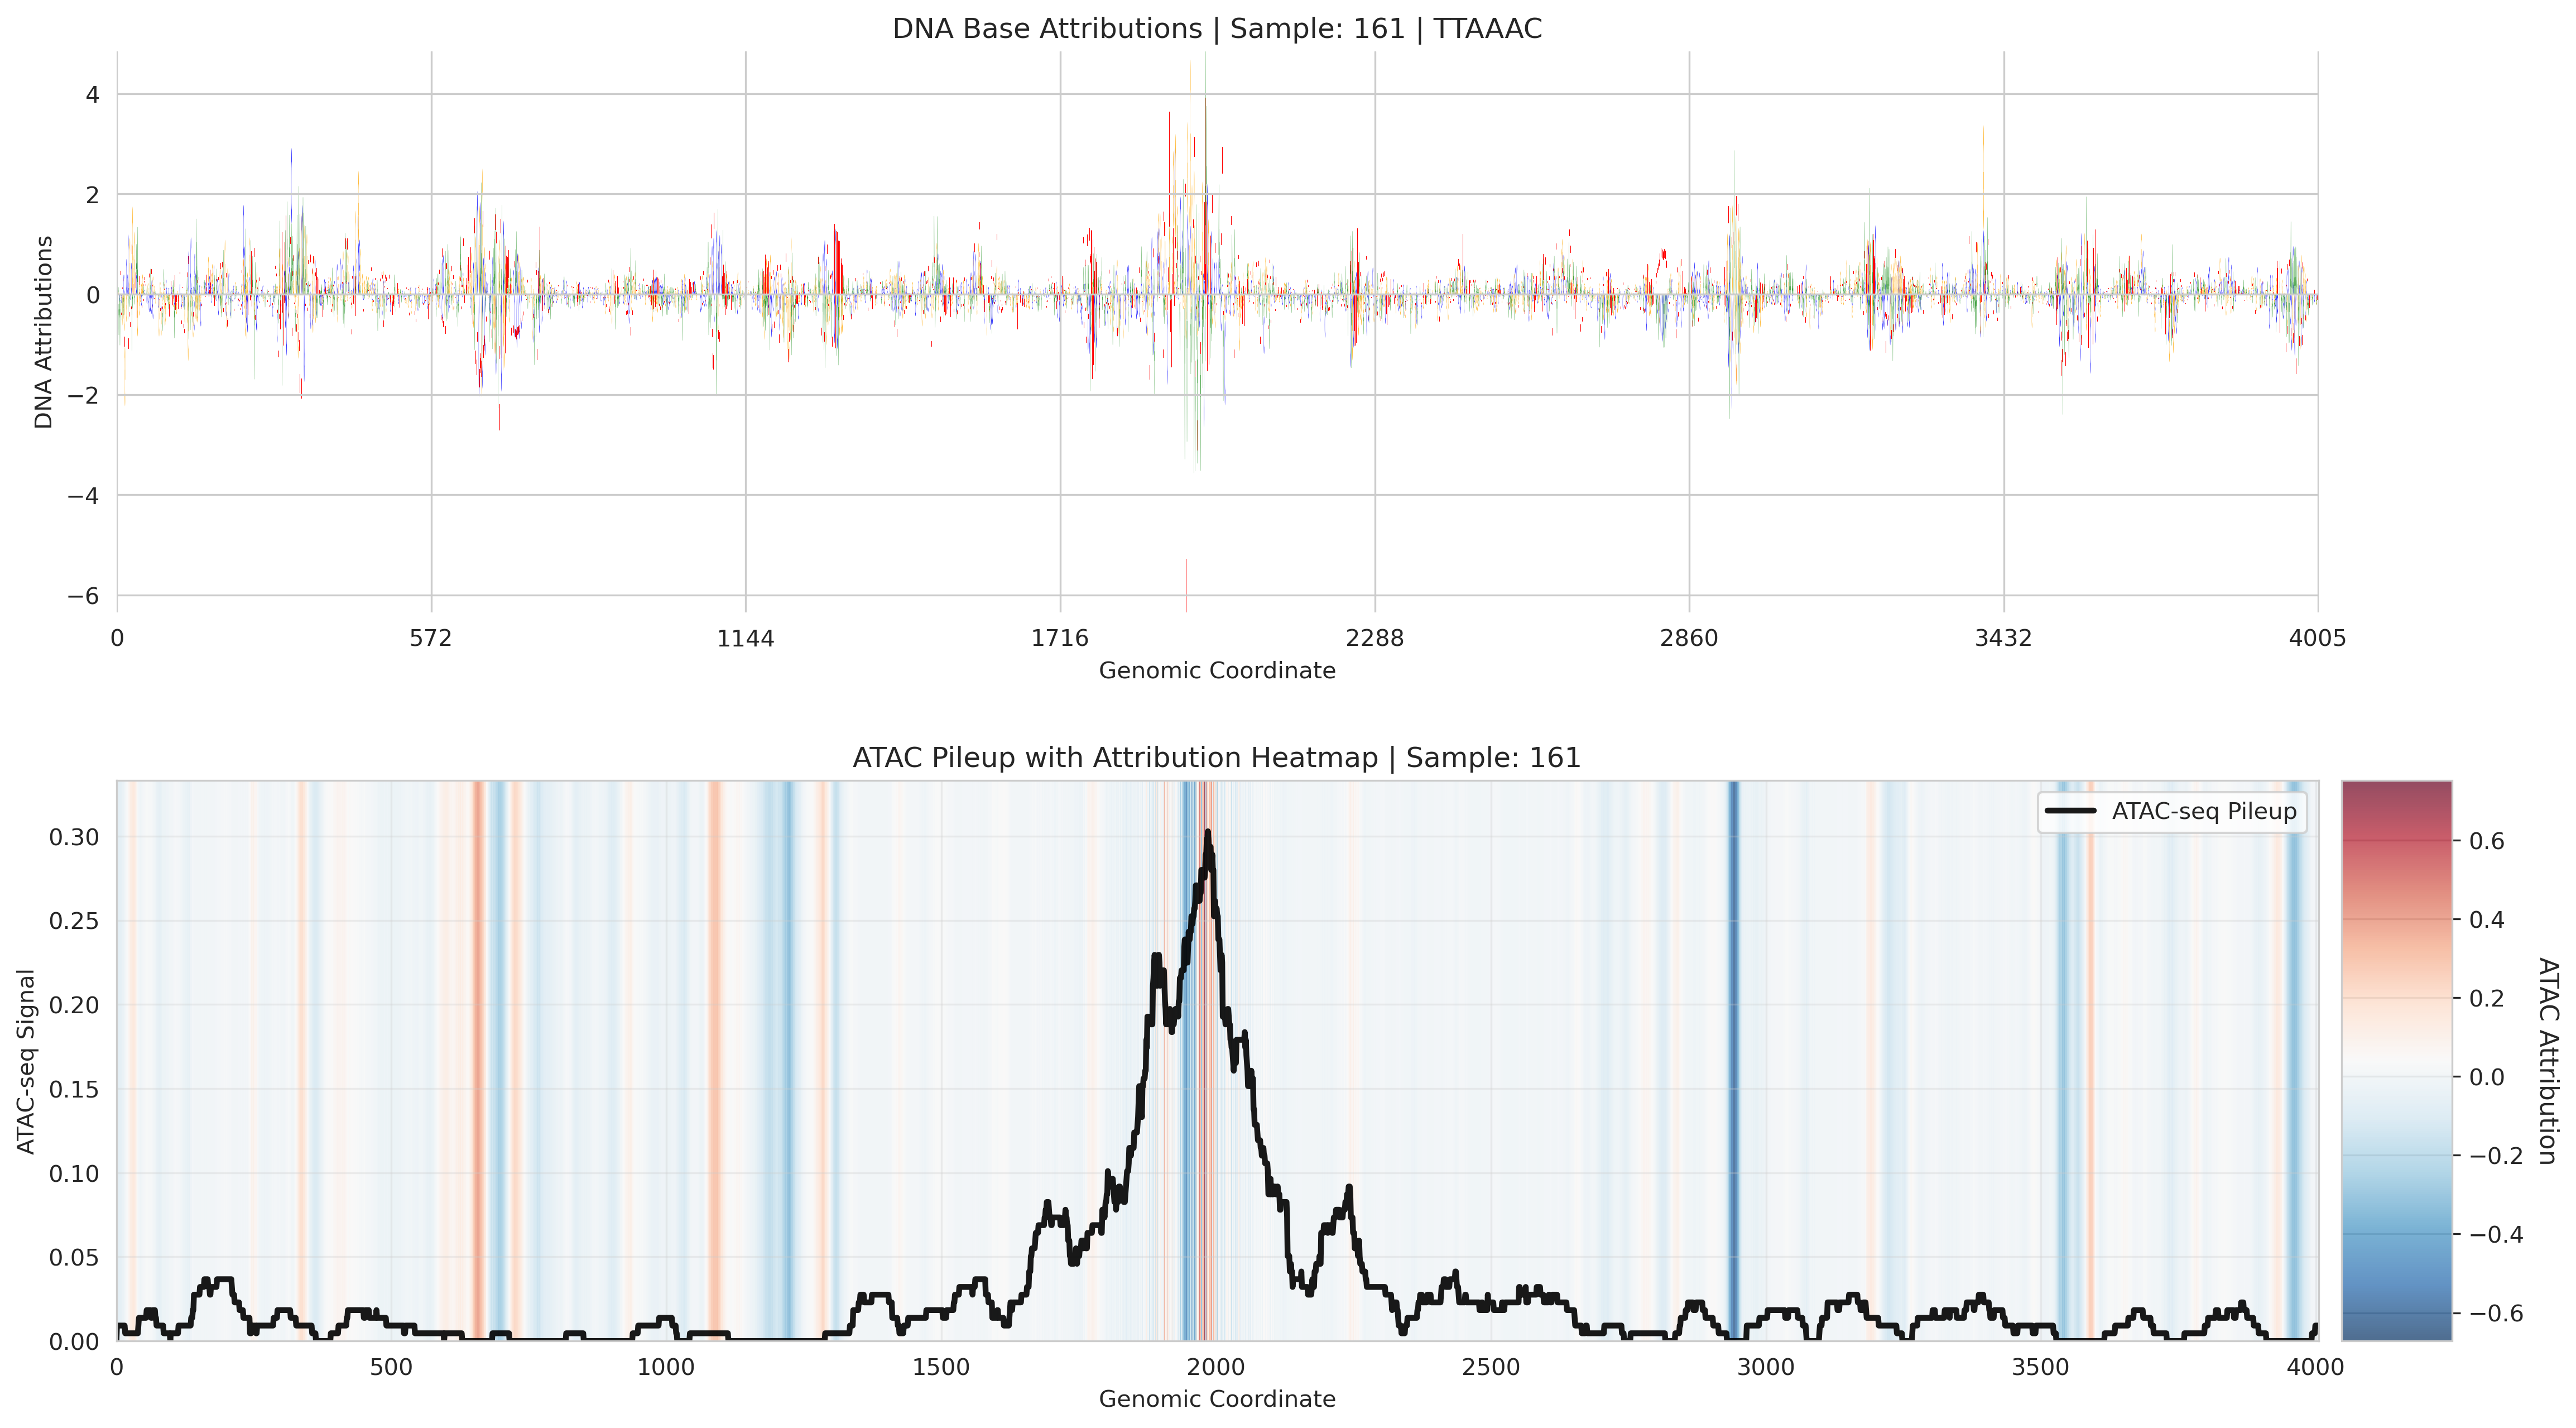

In [11]:
plot_seqlet_with_atac(seqlets, attrs_list,atac_attribution_list=atac_attribution_list, atac_pileup_list=atac_pileup_list, sample_rank=1, context_size=2000)
# how can we methodically identify patterns? brainstorrm a couple ideas
